# LSTM Text Classification

LSTM are a class of RNNs that are capable of learning long-term dependencies with feedback connections. In this project we use an LSTM model for classifying app review on a scale of 1 to 5.

This project focuses on text analytics which is the process of deriving high quality information from text.

Data link: https://www.kaggle.com/datasets/prakharrathi25/google-play-store-reviews

In [1]:
#Get required libraries
import re
import nltk
import time
import torch
import string
import numpy as np
import pandas as pd
import torch.nn as nn

In [17]:
# Ignore all warnings
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings(action='ignore')

In [2]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\uzmam\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [3]:
from nltk import PorterStemmer
import torch.nn.functional as F
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from sklearn.utils import resample
from sklearn.model_selection import train_test_split


In [4]:
data=pd.read_csv('review.csv')
data.head()

reviewId            userName  \
0  gp:AOqpTOFxf3fttcT5DSvFIn9KPp5FErgH9yC533Fmoxv...      Donna Caritero   
1  gp:AOqpTOEq6rNIWLnPV4KFTctWvm0mpGEQljtD6mvy1H-...  Soumi Mukhopadhyay   
2  gp:AOqpTOE86hSyPRHZgYt28Uk5zGe4FZGb1hkmtFDiYJ2...   Theknown _unknown   
3  gp:AOqpTOHSuKkVTcM3QgCCKysHQlxEnk2ocOKsUMiMIJy...        Anthony Dean   
4  gp:AOqpTOEOrZt5H6jXPiplJyffCd5ZBnVXACTWgwNsF1R...   Neha Diana Wesley   

                                           userImage  \
0  https://play-lh.googleusercontent.com/a-/AOh14...   
1  https://play-lh.googleusercontent.com/a-/AOh14...   
2  https://play-lh.googleusercontent.com/a-/AOh14...   
3  https://play-lh.googleusercontent.com/a/AATXAJ...   
4  https://play-lh.googleusercontent.com/a-/AOh14...   

                                             content  score  thumbsUpCount  \
0  Overall it's really an amazing app. I've been ...      4            528   
1  Hey! Yes I gave a 5 star rating... coz I belie...      5            351   
2  Canva used to be a good app! But recently I've...      1            160   
3  It's a brilliant app, but I have just one prob...      5            145   
4  This was such a great app. I used to make BTS ...      4            142   

  reviewCreatedVersion                   at  \
0              2.116.0  2021-06-17 07:18:54   
1              2.116.0  2021-06-17 19:18:28   
2              2.116.0  2021-06-23 19:13:28   
3              2.116.0  2021-06-19 23:36:07   
4              2.116.0  2021-06-21 00:29:27   

                                        replyContent            repliedAt  
0  Hi Donna. We are sorry that your text or desig...  2021-06-19 21:24:32  
1                                                NaN                  NaN  
2  Hi there. We're sorry to hear that you are hav...  2021-06-26 20:20:56  
3                                                NaN                  NaN  
4  Hi Neha. Sorry to hear that you are unable to ...  2021-06-24 20:46:28

In [5]:
data.isna().sum()

reviewId                  0
userName                  0
userImage                 0
content                   0
score                     0
thumbsUpCount             0
reviewCreatedVersion      0
at                        0
replyContent            977
repliedAt               977
dtype: int64

In [6]:
data.describe()

score  thumbsUpCount
count  1500.000000    1500.000000
mean      4.154000       1.591333
std       1.361195      18.936791
min       1.000000       0.000000
25%       4.000000       0.000000
50%       5.000000       0.000000
75%       5.000000       0.000000
max       5.000000     528.000000

Most of the reply content is not available, so that is not a very useful feature. Our analysis will be based off of the content column (although other features can  be explored as well).

In [7]:
df=data[['content','score']]


content  score
0  Overall it's really an amazing app. I've been ...      4
1  Hey! Yes I gave a 5 star rating... coz I belie...      5
2  Canva used to be a good app! But recently I've...      1
3  It's a brilliant app, but I have just one prob...      5
4  This was such a great app. I used to make BTS ...      4

In [8]:
pd.set_option('display.max_colwidth', -1)

C:\Users\uzmam\AppData\Local\Temp/ipykernel_26100/3652881321.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


In [9]:
df.head()

content  \
0  Overall it's really an amazing app. I've been using this for the past 5 years however I only have one issue though and I wanted this to get address since I think this issue had lasted for how many years? The texts were blurred and when you zoom it out it's pixelated. I thought this issue only occurs on mobile apps however it was also present on the website. Please fix this. I still remember the time when I can export high definition texts and I love that experience. Thank you!   
1  Hey! Yes I gave a 5 star rating... coz I believe it deserves it! I mostly use the desktop version and I am seriously so satisfied with this app in both android and desktop version. I just came here to thank the developers for this beautiful app and its facilities. I literally find almost everything that I need for and the best part is even without the premium feature it provides us with a lot many facilities. I love it! Thank you..! ❤                                              
2  Canva used to be a good app! But recently I've been facing issues in saving my files. When I want my files to be saved in '.png' format, it gets saved in .jpg format! Moreover when I want my files to be saved it gets stuck at the downloading screen (where your so called magic does not happen) For now you'll be getting 1 stars from me. I hope you will fix the app soon! Thank you .                                                                                                      
3  It's a brilliant app, but I have just one problem, if I'm editing a post and I double tap the photo to reposition, if I then start to zoom the photo, 8 times out of 10 my app crashes and restarts, this is on my LG G5 SE, sometimes I've had to go over to the desktop version on my PC just to reposition and zoom the photo where I want it to then resume editing back on my mobile.                                                                                                          
4  This was such a great app. I used to make BTS memes through this. But after recent update... I'm not able to change my font style. The edit option of font is missing. I tried uninstalling and installing the app, but still it's isn't working. The edit option for font is appearing very rarely. The previous version was far better. Canva could you please work on it! 💜                                                                                                                      

   score  
0  4      
1  5      
2  1      
3  5      
4  4

In [10]:
 # Defining a Function to Clean the Textual Data
 
def clean_text(txt):
    
  txt = txt.lower() #Lowering the text
  txt = re.sub(r'\W', ' ', str(txt)) # remove all special characters including apastrophie 
  txt = txt.translate(str.maketrans('', '', string.punctuation)) # remove punctuations
  txt = ''.join([i for i in txt if not i.isdigit()]).strip() # remove digits ()
  txt = re.sub(r'\s+[a-zA-Z]\s+', ' ', txt)   # remove all single characters (it's -> it s then we need to remove s)
  txt = re.sub(r'\s+', ' ', txt, flags=re.I) # Substituting multiple spaces with single space
  txt = re.sub(r"(http\S+|http)", "", txt) # remove links
  txt = ' '.join([PorterStemmer().stem(word=word) for word in txt.split(" ") if word not in stopwords.words('english') ]) # stem & remove stop words
  return txt

In [11]:
print('Original Text : ',data['content'][1])  
print('Processed Text : ',clean_text(data['content'][1]))

Original Text :  Hey! Yes I gave a 5 star rating... coz I believe it deserves it! I mostly use the desktop version and I am seriously so satisfied with this app in both android and desktop version. I just came here to thank the developers for this beautiful app and its facilities. I literally find almost everything that I need for and the best part is even without the premium feature it provides us with a lot many facilities. I love it! Thank you..! ❤
Processed Text :  hey ye gave star rate coz believ deserv mostli use desktop version serious satisfi app android desktop version came thank develop beauti app facil liter find almost everyth need best part even without premium featur provid us lot mani facil love thank


In [12]:
df['content'] = df['content'].apply(clean_text) #apply the function to every text in the dataset
df

C:\Users\uzmam\AppData\Local\Temp/ipykernel_26100/1120296784.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['content'] = df['content'].apply(clean_text) #apply the function to every text in the dataset


content  \
0     overal realli amaz app use past year howev one issu though want get address sinc think issu last mani year text blur zoom pixel thought issu occur mobil app howev also present websit pleas fix still rememb time export high definit text love experi thank   
1     hey ye gave star rate coz believ deserv mostli use desktop version serious satisfi app android desktop version came thank develop beauti app facil liter find almost everyth need best part even without premium featur provid us lot mani facil love thank     
2     canva use good app recent face issu save file want file save png format get save jpg format moreov want file save get stuck download screen call magic happen get star hope fix app soon thank                                                                  
3     brilliant app one problem edit post doubl tap photo reposit start zoom photo time app crash restart lg se sometim go desktop version pc reposit zoom photo want resum edit back mobil                                                                           
4     great app use make bt meme recent updat abl chang font style edit option font miss tri uninstal instal app still work edit option font appear rare previou version far better canva could pleas work                                                            
...                                                                                                                                                                                                    ...                                                            
1495  absolut amaz lifesav teacher                                                                                                                                                                                                                                    
1496  nice mani time show error open ppt school project disturb                                                                                                                                                                                                       
1497  much lag alway stuck start page worst app download                                                                                                                                                                                                              
1498  nice app colleg work mani featur templat work love                                                                                                                                                                                                              
1499  teacher much school year love                                                                                                                                                                                                                                   

      score  
0     4      
1     5      
2     1      
3     5      
4     4      
...  ..      
1495  5      
1496  3      
1497  1      
1498  5      
1499  5      

[1500 rows x 2 columns]

In [13]:
df.score.value_counts()

5    952
4    227
1    170
3    91 
2    60 
Name: score, dtype: int64

C:\Users\uzmam\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='score', ylabel='count'>

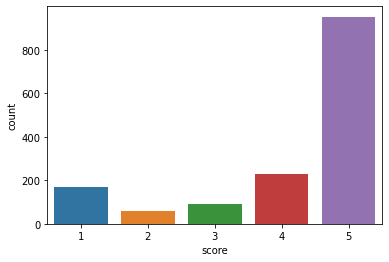

In [16]:
import seaborn as sns
sns.countplot(df['score'])

In [29]:
df_majority = df[df['score']==5] #Data with class 5

df_minority1= df[df['score']==2] #Data with class 2

df_minority2 = df[df['score']==3] #Data with class 3

df_minority3 = df[df['score']==1] #Data with class 1

df_minority4 = df[df['score']==4] #Data with class 4


In [30]:
#Down Sampling Majority Class "5"
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    
                                 n_samples = 600)
#Upsample Minority class  "2"
df_minority_upsampled = resample(df_minority1, 
                                 replace=True,     
                                 n_samples=200)
#Upsample Minority class "3"
df_minority_upsampled1 = resample(df_minority2, 
                                 replace=True,     
                                 n_samples=300)
#Upsample Minority class "1"
df_minority_upsampled2 = resample(df_minority3, 
                                 replace=True,     
                                 n_samples=225)
#Upsample Minority class "4"
df_minority_upsampled3 = resample(df_minority4, 
                                 replace=True,     
                                 n_samples=250)


# Combine minority class with downsampled majority class
data1 = pd.concat([df_majority_downsampled, df_minority_upsampled,df_minority_upsampled1,df_minority_upsampled2,df_minority_upsampled3])

This is a multi-class imbalanced classification problem.

<AxesSubplot:xlabel='score', ylabel='count'>

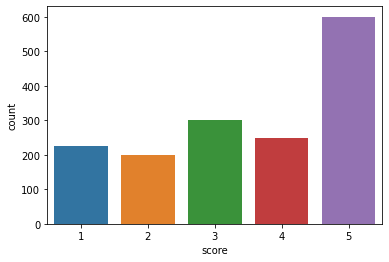

In [31]:
sns.countplot(data1['score'])

In [32]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 2000
# Max number of words in each Content.
MAX_SEQUENCE_LENGTH = 600
# This is fixed. Embedding
EMBEDDING_DIM = 120
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(data1['content'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 1349 unique tokens.


In [33]:
#Tokenizing the content
 
X = tokenizer.texts_to_sequences(data1['content'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape[1])

Shape of data tensor: 600


In [34]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
Y = le.fit_transform(data1['score'])
print(Y.shape)
print(le.classes_)
Y.dtype

(1575,)
[1 2 3 4 5]


dtype('int64')